In [37]:
import numpy as np
import xarray

import matplotlib as mpl
from matplotlib import pyplot as plt

import netCDF4
from netCDF4 import Dataset

from bokeh.plotting import figure, output_notebook, show
output_notebook()
from IPython.display import IFrame

YEAR = 8766 # One year is 8766 hours
MONTH = 730.5 # One month is 730.5 hours
DATETIME_FMT = "%Y-%m-%d %H:%M"

Loading BokehJS ...

In [38]:
# https://github.com/jegesm/Presentation-tricks/blob/master/Jupyter/Change-the-outlook.md
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.slides {bottom: 0px !important; overflow-y: auto !important;}</style>"))
# Hide scrollbar 
# display(HTML("<style>.slides {\
#     ::-webkit-scrollbar {\
#         width: 0px;\
#         background: transparent;\
#     }\
# }</style>"))
#display(HTML("<script>Reveal.configure({ touch: false });</script>"))

In [39]:
ds = Dataset("./data/ERA5-hourly-merged.nc")
stl2 = np.array(ds.variables['stl2'])
long = np.array(ds.variables['longitude'])
lat = np.array(ds.variables['latitude'])

print("lat = {} long = {}".format(lat[0], long[0]))
# the relevant data is stl2[0][0]
temps = np.array([x[0][0] for x in stl2]).astype(float)
hours = np.array(ds.variables['time']) 

# Helper functions
from datetime import datetime
from datetime import timezone

def datetimeToHour(dt):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_dt = datetime.strptime(dt, DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    return int((ts_dt-ts_null)//3600-692496)
datetimeToHour = np.vectorize(datetimeToHour)

def hourToTimestamp(h):
    ts_null = datetime.strptime('1900-01-01 00:00', DATETIME_FMT).replace(tzinfo=timezone.utc).timestamp()
    ts_date = int(ts_null) + 692496*3600 + 3600*h
    return ts_date
hourToTimestamp = np.vectorize(hourToTimestamp)

def hourToUTC(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts)
hourToUTC = np.vectorize(hourToUTC)

def hourToUTCFormatted(h):
    ts = hourToTimestamp(h)
    return datetime.utcfromtimestamp(ts).strftime(DATETIME_FMT)
hourToUTCFormatted = np.vectorize(hourToUTCFormatted)

def getYearBeforeDateTime(dt):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-YEAR
    return hr_start, hr_end

def getMonthsBeforeDateTime(dt, nmonths):
    hr_end = datetimeToHour(dt)
    hr_start = hr_end-int(nmonths*MONTH)
    return hr_start, hr_end
  
def getYearBeforeTimestamp(ts):
    pass
  
import ephem     # provides scientific-grade astronomical computations
"""
IMPORTANT:
PyEphem dates are encoded as the “Dublin Julian Day”, which is the number of
days (including any fraction) that have passed since the last day of 1899, at noon. 
"""
def getsoltime(dt, long):
    gamma = 2. * np.pi / 365. * (dt.timetuple().tm_yday - 1 + float(dt.hour - 12) / 24)
    eqtime = 229.18 * (0.000075 + 0.001868 * np.cos(gamma) - 0.032077 * np.sin(gamma) \
             - 0.014615 * np.cos(2 * gamma) - 0.040849 * np.sin(2 * gamma))
    decl = 0.006918 - 0.399912 * np.cos(gamma) + 0.070257 * np.sin(gamma) \
           - 0.006758 * np.cos(2 * gamma) + 0.000907 * np.sin(2 * gamma) \
           - 0.002697 * np.cos(3 * gamma) + 0.00148 * np.sin(3 * gamma)
    time_offset = eqtime + 4 * long
    tst = dt.hour * 60 + dt.minute + dt.second / 60 + time_offset
    solar_time = datetime.combine(dt.date(), time(0)) + timedelta(minutes=tst)
    return solar_time
  
def getsunrise_sunset(date, lat=47.5, lon=19.0):
    iss = ephem.Observer()
    iss.date = date
    iss.lat = str(lat)                     # IMPORTANT TO CONVERT INTO STRING!!!
    iss.lon = str(lon)
    iss.elevation = 130                   # elevation of Albertfalva (in units of m)
    sun = ephem.Sun()
    r1 = iss.next_rising(sun)
    s1 = iss.next_setting(sun)
    return r1,s1

lat = 47.5 long = 19.0


# The system of equations in the LSCD model

- The unspliced VIN3 concentration is denoted with $\nu$
- The spliced VIN3 concentration is denoted with V
$$
\begin{equation*}
\frac{\mathrm d\nu}{\mathrm d t} = p_{\nu}(L, S, C, D) - s_{\nu}\nu\\
\frac{\mathrm dV}{\mathrm dt} = s_{\nu}\nu - d_VV
\end{equation*}
$$
- Here, $p_{\nu}(L, S, C, D)=LSCD$ is the productive transcription, $s_{\nu}$ is the splicing rate, and $d_V$ is the degradation rate of the spliced VIN3.

$$
\begin{equation*}
\frac{\mathrm dL}{\mathrm dt} =
\begin{cases}
1-d_LL & T < T_L \\
-d_LL & T \geq T_L
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
C(T) =
\begin{cases}
p_{c1} & T \leq T_{c1} \\
p_{c1}-p_{c2}\frac{T-T_{c1}}{T_{c2}-T_{c1}} & T_{c1} < T < T_{c2} \\
p_{c2} & T \geq T_{c2}
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
S(T_m) = 
\begin{cases}
1, & T < T_S \\
S_1, & T \geq T_S
\end{cases}
\end{equation*}
$$

$$
\begin{equation*}
D(t) =  \left[p_D + \sin\left(2\pi\left(t - \frac{t_m-1}{24}\right)\right)\right]^2
\end{equation*}
$$
- $T_m$ is the maximum temperature since the last resetting, which was chosen to occur each day at 4pm.
- $t_m$ is the time at dawn.

Initial guess for parameters:

| param     | dimension | value in the article |
|:---------:|-----------|----------------------|
| $d_V$     | day$^{-1}$| 18 |
| $s_{\nu}$ | day$^{-1}$|4.4$d_V$|
| $S_1$     | 1 | 0.75 |
| $T_L$     | $^{\circ}$C | 17 |
| $d_L$     | day$^{-1}$| 0.009 |
| $T_{c1}$  | $^{\circ}$C | 8 |
| $T_{c2}$  | $^{\circ}$C | 15.4 |
| $p_{c1}$  | 1 | 0.0315 |
| $p_{c2}$  | 1 | 0.03   |
| $p_D$     | 1 | 2.05 |
| $T_S$     | $^{\circ}$C | 15 |

In [40]:
# LSCD model parameters
dV = 18.
snu = 4.4*dV
S1 = 0.75
TL = 17
dL = 0.009
Tc1 = 8
Tc2 = 15.4
pc1 = 0.0315
pc2 = 0.03
pD = 2.05
TS = 15

In [41]:
def Tm(hour):
    # Calculate Tmax since the last resetting for a given hour
    delta = 0
    if hour%24 >= 16:
        delta = hour%24 - 16
    else:
        delta = 8 + hour%24 
    slc = slice(hour-delta, hour)
    if delta == 0:
        return temps[hour]
    else:
      return np.max(temps[slc])
Tm = np.vectorize(Tm)

def tm(hour):
    # Calculate time at dawn for a given hour
    date = ephem.Date(str(hourToUTCFormatted(hour)))
    rs1, st1 = getsunrise_sunset(date)
    formatted = datetime.strftime(rs1.datetime(), DATETIME_FMT)
    return datetimeToHour(formatted)
tm = np.vectorize(tm)

def dLdt(L, T):
    # L is the current value of L, 
    # T is the current temperature
    T = T - 273.15
    if T < TL:
        return 1-dL*L
    else:
        return -dL*L
dLdt = np.vectorize(dLdt)

def S(Tm):
    # Tm is the maximum temperature since the last resetting,
    # which was chosen to occur each day at 4pm.
    Tm = Tm - 273.15
    if Tm < TS:
        return 1.0
    else: 
        return S1
S = np.vectorize(S)

def C(T):
    # T is the current temperature
    T = T - 273.15
    if T <= Tc1:
        return pc1
    elif T < Tc2:
        return pc1 - pc2*((T-Tc1)/(Tc2-Tc1))
    else:
        return pc2
C = np.vectorize(C)      
      
def D(t):
    # tm is the time at dawn
    # We expect a sine wave for each day
    return ( pD + np.sin(2*np.pi*(t - (tm(t)-1)/24.0)) )**2
D = np.vectorize(D)

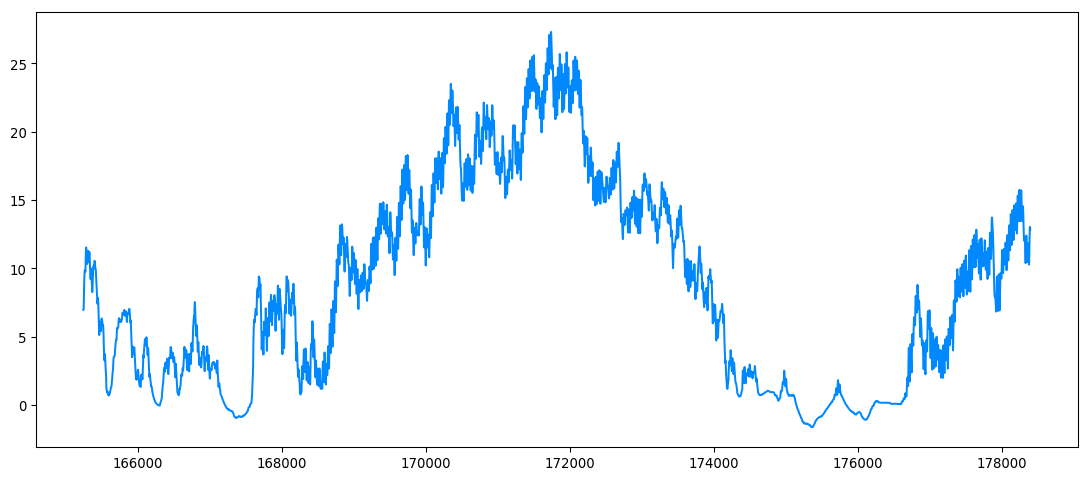

In [42]:
date = '1999-05-09 00:00'
hr_start, hr_end = getMonthsBeforeDateTime(date, 18)

t = hours[hr_start:hr_end]
Ts = temps[hr_start:hr_end]

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ts - 273.15, color="#0088ff")

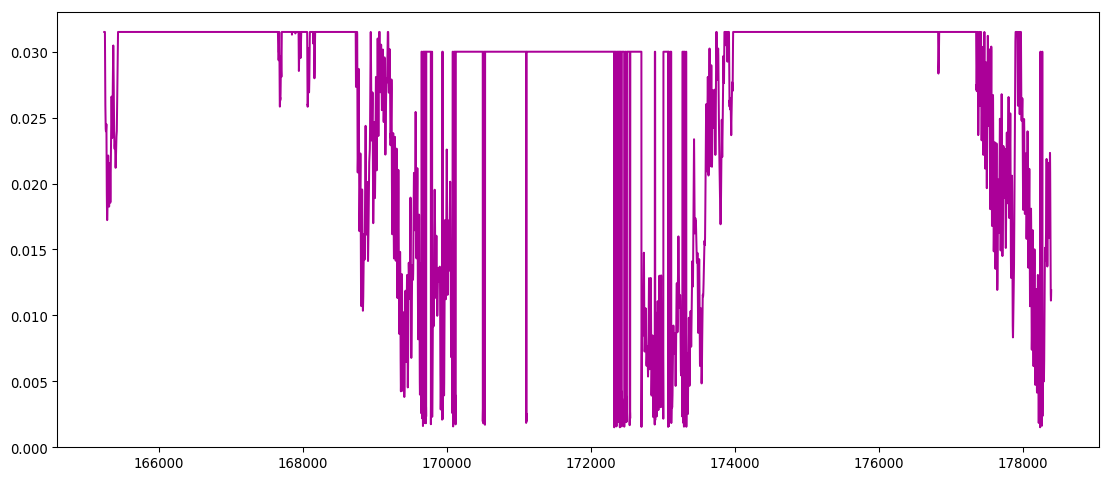

In [43]:
Cs = C(Ts)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Cs, '-', color='#ab0098')

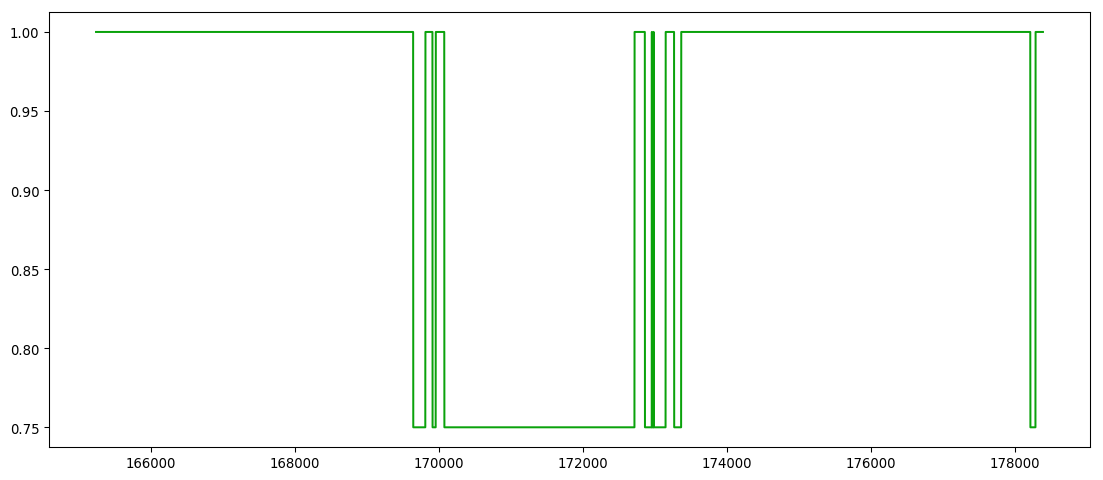

In [44]:
Ss = S( Tm(t) )

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ss, color="#0aa20b")

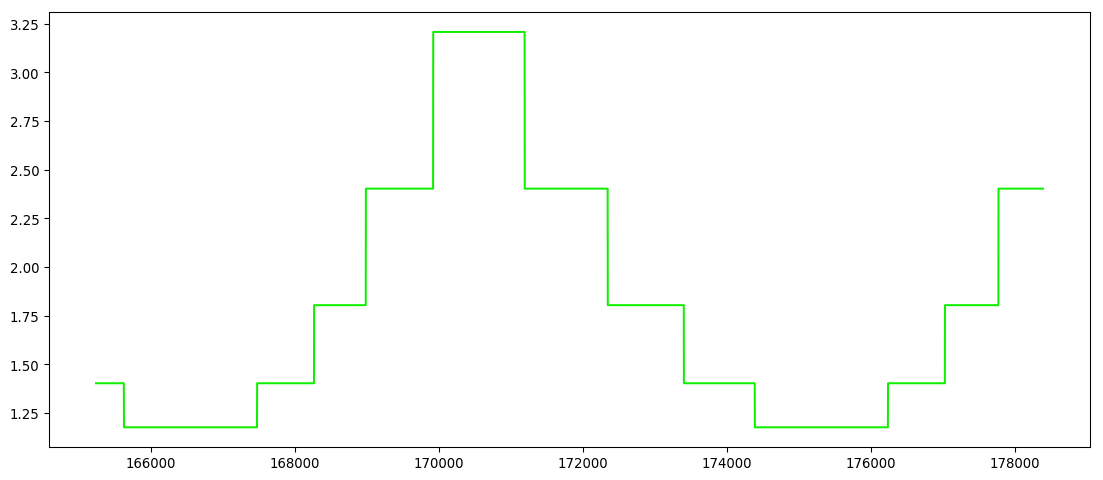

In [45]:
Ds = D(t)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ds, color="#0ff000")


tm%24 =  [5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]

tt%24-(tm(tt)-1)%24 =  [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2
 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2
 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2
 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2
 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2
 -1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 -4 -3 -2]


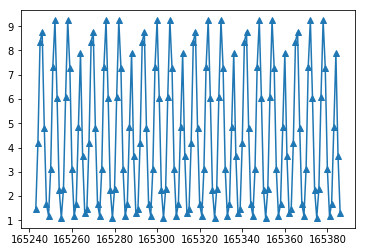

In [83]:
tt = t[:6*24]
# print("tt =", tt)
# print("\ntm =",tm(tt))

print("\ntm%24 = ", tm(tt)%24)
print("\ntt%24-(tm(tt)-1)%24 = ", tt%24-(tm(tt)-1)%24)
def D(t):
    # tm is the time at dawn
    # We expect a sine wave for each day
    t_m = tm(t)
    t = t%24
    return ( pD + np.sin(2*np.pi*(t - (t_m-1)/24.0)) )**2
D = np.vectorize(D)
plt.plot(
  tt,
  (pD + np.sin(tt%24-(tm(tt)-1)%24) )**2,
  '^-'
)

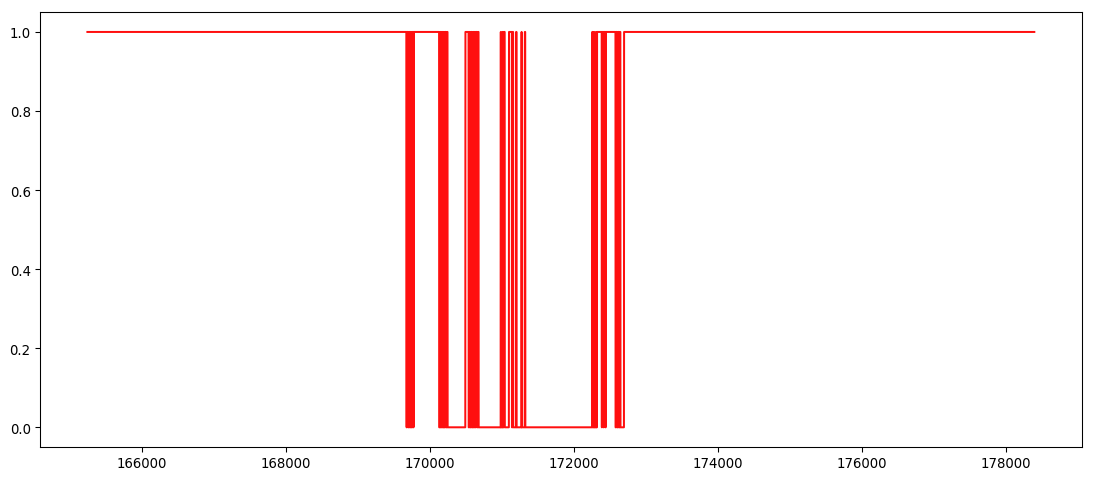

In [46]:
Ls = np.zeros_like(t)
L0 = 1.0
Ls[0] = L0
h = t[1]-t[0]

for k in range(len(Ls)-1):
  Ls[k+1] = Ls[k] + dLdt(Ls[k], Ts[k])

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, Ls, color="#ff0f0f")

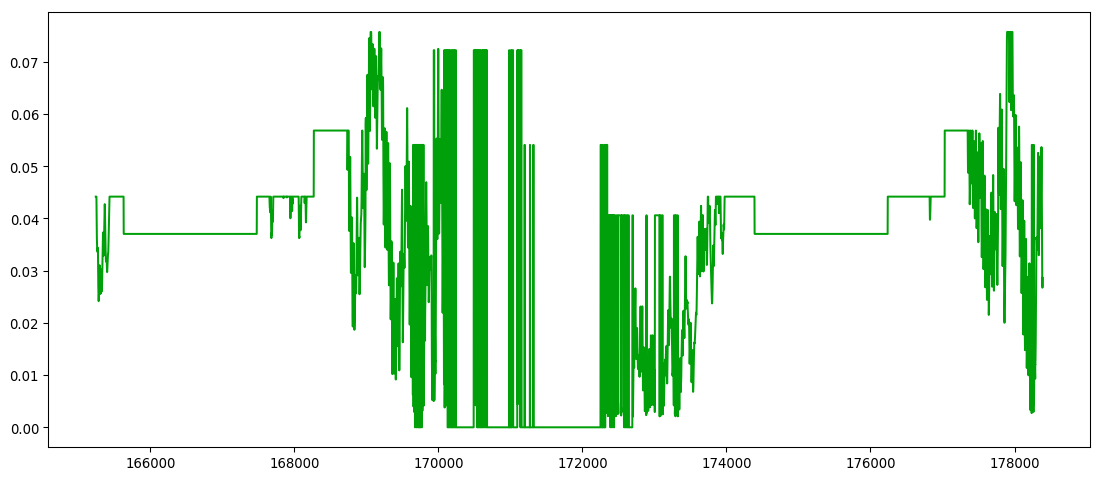

In [47]:
p_nu = Ls*Ss*Cs*Ds

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, p_nu, color="#00A00A")

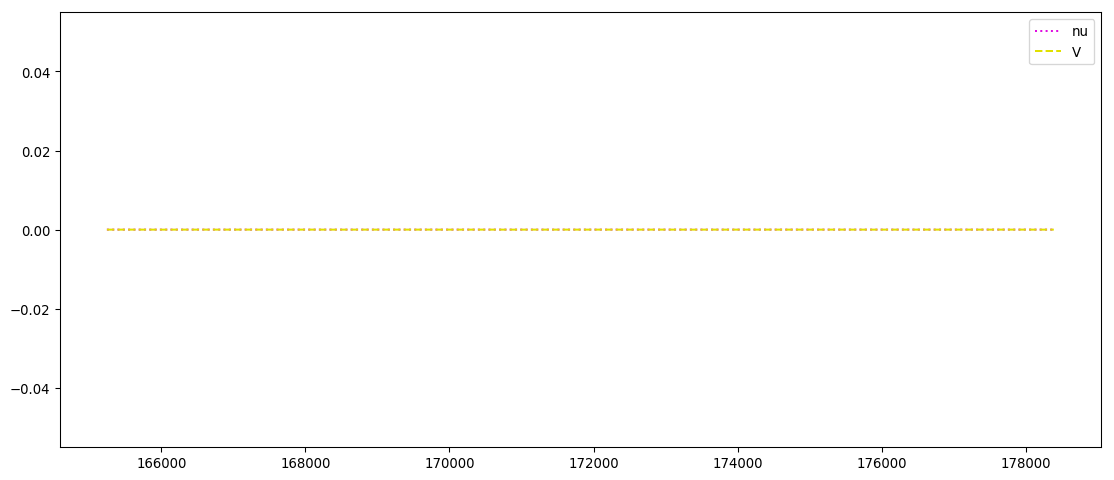

In [79]:
def dnudt(p_nu, nu):
   return p_nu-snu*nu
def dVdt(V, nu):
   return snu*nu - dV*V
  
nus = np.zeros_like(t)
Vs = np.zeros_like(t)
nus[0] = 0.5e-2
Vs[0] = 1.0e-1

h = t[1]-t[0]
for k in range(len(nus)-1):
  try:
    nus[k+1] = nus[k] + h*dnudt(p_nu[k], nus[k])
    Vs[k+1] = Vs[k] + h*dVdt(Vs[k], nus[k])
  except Exception as e:
    print("Error at step {}:".format(k))
    print(e)

plt.figure(figsize=(14,6), dpi=96)
plt.plot(t, nus, ':', label="nu", color="#E00EE0")
plt.plot(t, Vs, '--', label="V", color="#E0E000")
plt.legend()

# Loading measurements

In [13]:
!ls -lah ./data

total 71080
drwxr-xr-x  14 nagydaniel  staff   448B Sep 24 12:50 .
drwxr-xr-x  18 nagydaniel  staff   576B Nov  5 13:11 ..
-rw-r--r--@  1 nagydaniel  staff   6.0K Oct  1 18:16 .DS_Store
-rw-r--r--   1 nagydaniel  staff    14M Sep 24 12:49 ERA5-hourly-merged.nc
-rw-r--r--   1 nagydaniel  staff    14M Sep 24 12:49 ERA5-hourly-merged_backup.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:26 ERA5-hourly-temps-0_1_2h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:29 ERA5-hourly-temps-12_13_14h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:43 ERA5-hourly-temps-15_16_17h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:27 ERA5-hourly-temps-18_19_20h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:27 ERA5-hourly-temps-21_22_23h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:36 ERA5-hourly-temps-3_4_5h.nc
-rwxrwxrwx   1 nagydaniel  staff   888K Sep 17 16:26 ERA5-hourly-temps-6_7_8h.nc
-rwxrwxrwx@  1 nagydaniel  staff   888K Sep 17 16:29 ERA5-hourly-temps-9_10_11

In [14]:
import pandas as pd

# The table contains first flowering dates of 329 taxa over 33 years
# numbers are the day of year
df = pd.read_csv('./data/V_KEZD_Excel_SORTED_cut.csv')

In [15]:
df

,"Egyedsz.(E.sz.) 1=1-5db, 2=6-10db, 3=10 feletti db",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38
0,E.sz.,1968,1969.0,1970.0,1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,...,1996.0,1997.0,1998.0,1999.0,2000.0,MEAN,STD,1st yr.,Last yr.,Nr.of yrs
1,3,46,61.0,66.0,39.0,41.0,31.0,25.0,5.0,37.0,...,63.0,37.0,20.0,57.0,39.0,36.3030303,15.89947252,NaN,NaN,33
2,3,46,62.0,68.0,42.0,46.0,39.0,37.0,19.0,51.0,...,59.0,37.0,17.0,57.0,32.0,37.72727273,16.27389235,NaN,NaN,33
3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,37.0,...,60.0,30.0,22.0,57.0,37.0,41.91304348,14.99975845,NaN,NaN,22.5
4,3,49,68.0,72.0,44.0,48.0,42.0,37.0,17.0,57.0,...,66.0,37.0,20.0,57.0,40.0,42.42424242,17.96897703,NaN,NaN,33
5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,...,75.0,47.0,46.0,58.0,45.0,46.45833333,13.35658389,NaN,NaN,23.5
6,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.0,46.0,...,NaN,60.0,20.0,65.0,51.0,47.13043478,13.24230704,NaN,NaN,22
7,3,NaN,NaN,NaN,65.0,55.0,52.0,47.0,54.0,52.0,...,64.0,48.0,37.0,58.0,38.0,50.17241379,14.94312523,NaN,NaN,29.5
8,2,47,63.0,72.0,49.0,52.0,48.0,41.0,47.0,59.0,...,65.0,NaN,NaN,NaN,NaN,50.17391304,13.26854731,NaN,NaN,23
9,3,49,69.0,70.0,46.0,53.0,37.0,39.0,44.0,53.0,...,75.0,47.0,43.0,58.0,41.0,50.87878788,12.62760183,NaN,NaN,33


In [16]:
# Iterative differential equations
tt = np.linspace(0, 5, 100)
y = np.zeros_like(tt)
y[0] = 1

alpha = 0.3
def dydt(y, t):
    return -alpha*y
  
h = tt[1]-tt[0]
for k in range(len(y)-1):
    y[k+1] = y[k] + h*dydt(y[k], k)

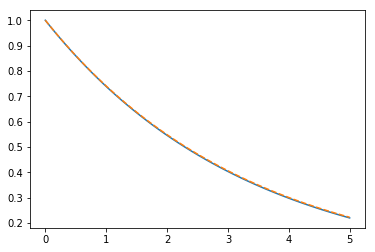

In [17]:
plt.plot(tt, y)
plt.plot(tt, y[0]*np.exp(-alpha*tt), '--')